# Multivariate Forecasting  
This notebook outlines an example of scalecast using multiple series to forecast one another using scikit-learn models.

The data is available on Kaggle: https://www.kaggle.com/datasets/neuromusic/avocado-prices  
See the blog post: https://towardsdatascience.com/multiple-series-forecast-them-together-with-any-sklearn-model-96319d46269  

In [ ]:
!pip install statsmodels==0.13.2

In [191]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster
from scalecast.MVForecaster import MVForecaster
from scalecast.multiseries import export_model_summaries
from scalecast import GridGenerator


In [192]:
# read data
data = pd.read_csv('avocado.csv',parse_dates=['Date']).sort_values(['Date'])
# sort appropriately (not doing this could cause issues)
data = data.sort_values(['region','type','Date'])
data

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
51,51,2015-01-04,1.2200,40873.2800,2819.5000,28287.4200,49.9000,9716.4600,9186.9300,529.5300,0.0000,conventional,2015,Albany
50,50,2015-01-11,1.2400,41195.0800,1002.8500,31640.3400,127.1200,8424.7700,8036.0400,388.7300,0.0000,conventional,2015,Albany
49,49,2015-01-18,1.1700,44511.2800,914.1400,31540.3200,135.7700,11921.0500,11651.0900,269.9600,0.0000,conventional,2015,Albany
48,48,2015-01-25,1.0600,45147.5000,941.3800,33196.1600,164.1400,10845.8200,10103.3500,742.4700,0.0000,conventional,2015,Albany
47,47,2015-02-01,0.9900,70873.6000,1353.9000,60017.2000,179.3200,9323.1800,9170.8200,152.3600,0.0000,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18241,4,2018-02-25,1.5700,18421.2400,1974.2600,2482.6500,0.0000,13964.3300,13698.2700,266.0600,0.0000,organic,2018,WestTexNewMexico
18240,3,2018-03-04,1.5400,17393.3000,1832.2400,1905.5700,0.0000,13655.4900,13401.9300,253.5600,0.0000,organic,2018,WestTexNewMexico
18239,2,2018-03-11,1.5600,22128.4200,2162.6700,3194.2500,8.9300,16762.5700,16510.3200,252.2500,0.0000,organic,2018,WestTexNewMexico
18238,1,2018-03-18,1.5600,15896.3800,2055.3500,1499.5500,0.0000,12341.4800,12114.8100,226.6700,0.0000,organic,2018,WestTexNewMexico


We will be forecasting the organic and conventional avocado sales from California only.

In [193]:
data_cali = data.loc[data['region'] == 'California']
data_cali_org = data_cali.loc[data_cali['type'] == 'organic']
data_cali_con = data_cali.loc[data_cali['type'] == 'conventional']
data_cali_con[['Total Volume', 'Date']]

,Total Volume,Date
363,5777334.9000,2015-01-04
362,6024932.3400,2015-01-11
361,5570915.2600,2015-01-18
360,4929884.2600,2015-01-25
359,9032180.6700,2015-02-01
...,...,...
8554,6750361.4600,2018-02-25
8553,6295529.6100,2018-03-04
8552,6488605.4300,2018-03-11
8551,6802084.1100,2018-03-18


## Choose Models and Import Validation Grids

In [194]:
# download template validation grids (will not overwrite existing Grids.py file by default)
# models = ('mlr','elasticnet','knn','rf','gbt','xgboost','mlp')
models = ('knn', 'xgboost')
GridGenerator.get_example_grids()
GridGenerator.get_mv_grids()

## EDA

### Plot

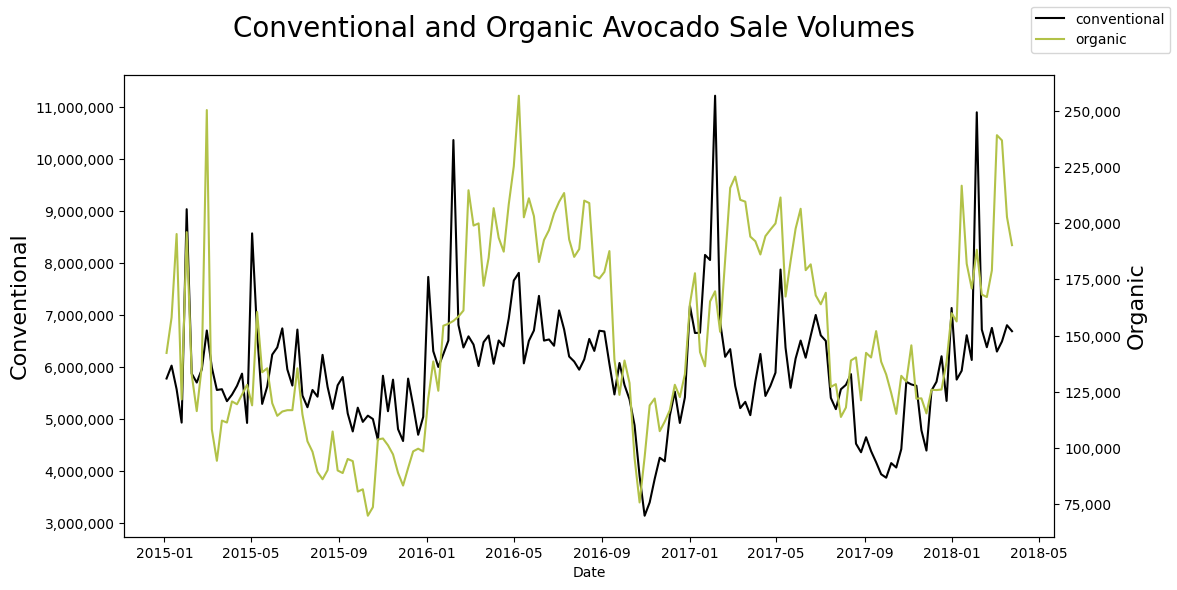

In [195]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x='Date',y='Total Volume',data=data_cali_con,label='conventional',ax=ax,color='black',legend=False)
plt.ylabel('Conventional',size=16)
ax2 = ax.twinx()
sns.lineplot(x='Date',y='Total Volume',data=data_cali_org,label='organic',ax=ax2,color='#B2C248',legend=False)
ax.figure.legend()
plt.ylabel('Organic',size=16)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.suptitle('Conventional and Organic Avocado Sale Volumes',size=20)
plt.show()

### Examine Correlation between the series

In [196]:
corr = np.corrcoef(data_cali_org['Total Volume'].values,data_cali_con['Total Volume'].values)[0,1]
print('{:.2%}'.format(corr))

48.02%


### Load into Forecaster from scalecast

In [198]:
fcon = Forecaster(y=data_cali_con['Total Volume'],current_dates = data_cali_con['Date'])
fcon

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

In [200]:
forg = Forecaster(y=data_cali_org['Total Volume'],current_dates = data_cali_org['Date'])
forg

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

### ACF and PACF Plots

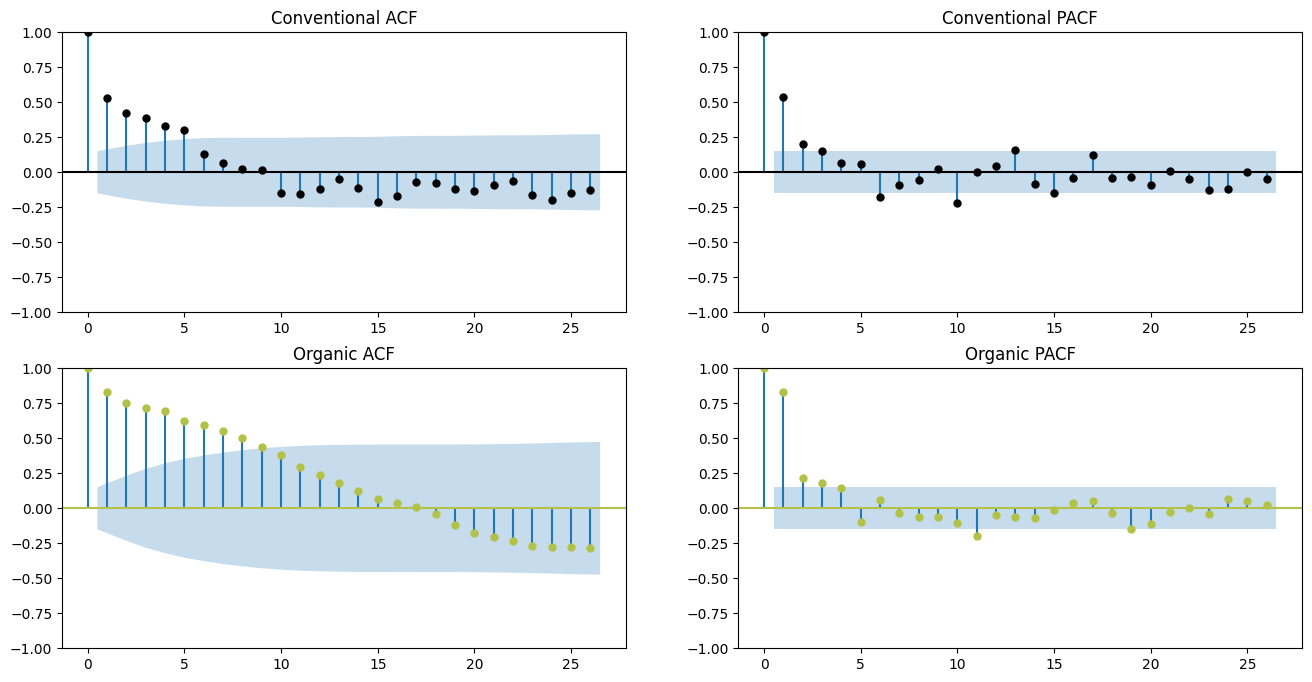

In [201]:
figs, axs = plt.subplots(2, 2,figsize=(16,8))
fcon.plot_acf(ax=axs[0,0],title='Conventional ACF',lags=26,color='black')
fcon.plot_pacf(ax=axs[0,1],title='Conventional PACF',lags=26,color='black')
forg.plot_acf(ax=axs[1,0],title='Organic ACF',lags=26,color='#B2C248')
forg.plot_pacf(ax=axs[1,1],title='Organic PACF',lags=26,color='#B2C248')
plt.show()

### Seasonal Decomposition Plots

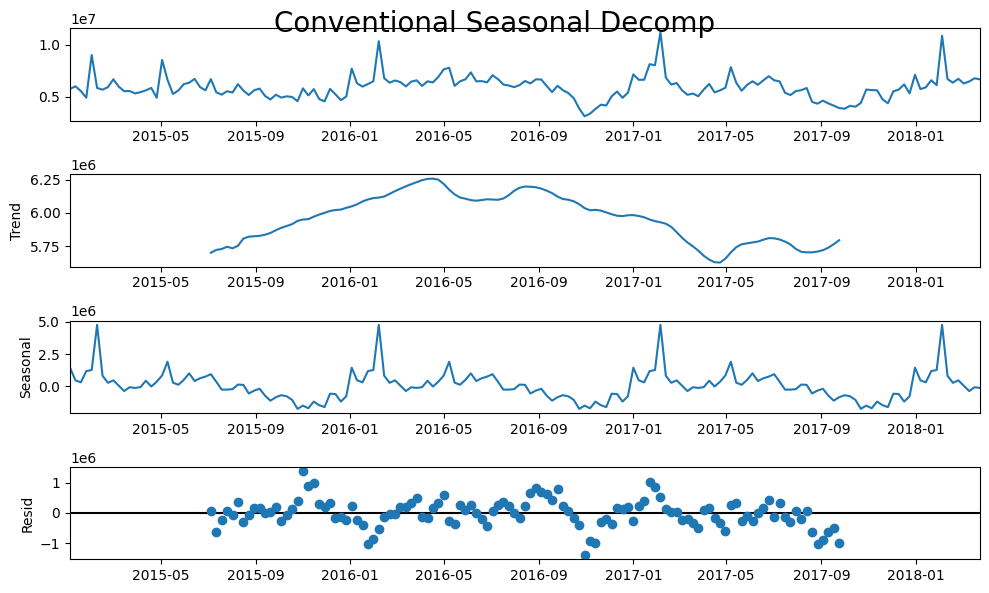

In [202]:
plt.rc("figure",figsize=(10,6))
fcon.seasonal_decompose().plot()
plt.suptitle('Conventional Seasonal Decomp',size=20)
plt.show()

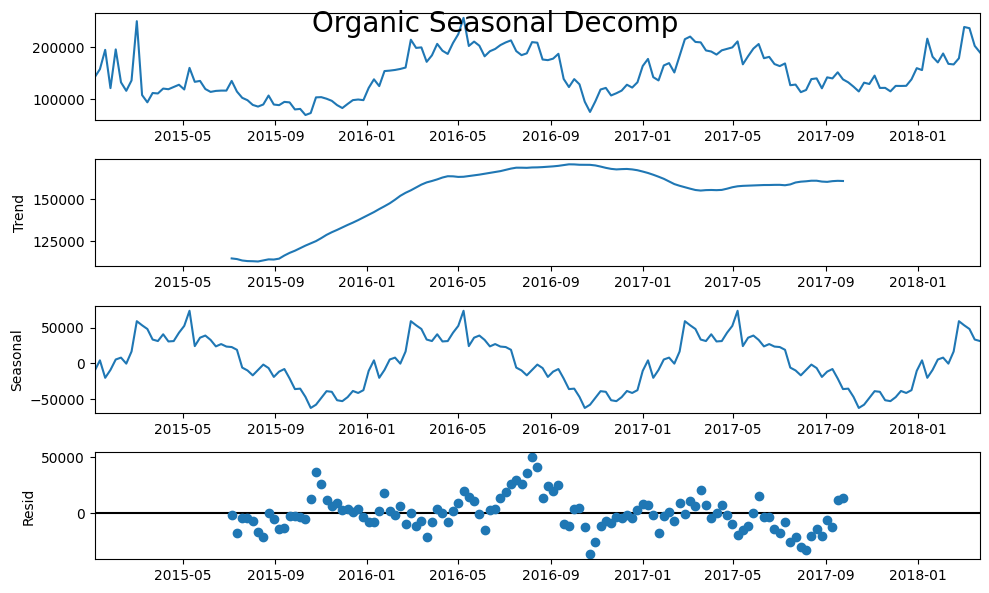

In [203]:
forg.seasonal_decompose().plot()
plt.suptitle('Organic Seasonal Decomp',size=20)
plt.show()

### Check Stationarity

In [204]:
critical_pval = 0.05
print('-'*100)
print('Conventional Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = fcon.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)
print('Organic Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = forg.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Conventional Augmented Dickey-Fuller results:
the test-stat value is: -3.35
the p-value is 0.0128
the series is stationary
----------------------------------------------------------------------------------------------------
Organic Augmented Dickey-Fuller results:
the test-stat value is: -2.94
the p-value is 0.0404
the series is stationary
----------------------------------------------------------------------------------------------------


## Scalecast - Univariate

### Load Objects with parameters:
- Forecast horizon (52 weeks)
- Test length (20%)
- Validation length (4 periods)
- Seasonal regressor (week, month, quarter)
- Irregular Cycle (26 weeks)
- Dep Var Lags (3)

In [205]:
for f in (fcon,forg):
    f.generate_future_dates(52)
    f.set_test_length(.2)
    f.set_validation_length(4)
    f.add_seasonal_regressors('week','month','quarter',raw=False,sincos=True)
    f.add_seasonal_regressors('year')
    f.add_time_trend()
    f.add_cycle(26)
    f.add_ar_terms(3)

### Tune and Forecast with Selected Models

#### Conventional

In [206]:
fcon.tune_test_forecast(models,feature_importance=True)
fcon.set_estimator('combo')
fcon.manual_forecast(how='weighted')

166
52
169


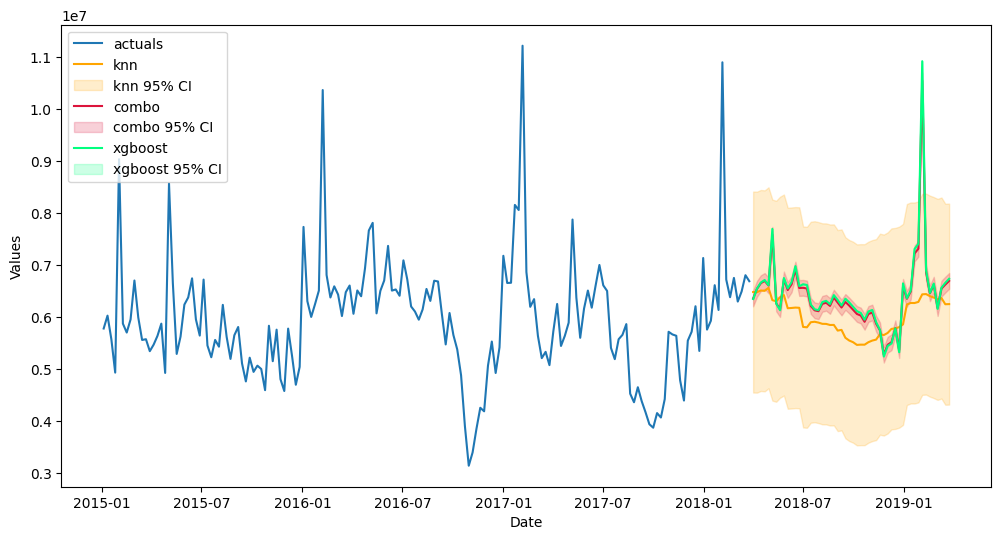

In [226]:
from scalecast.Pipeline import Pipeline

pipeline = Pipeline(steps=[])

f = pipeline.fit_predict(fcon, modes=models)
print(len(f.fitted_values))
print(len(f.future_dates))
print(len(f.y))

# plot results
f.plot(ci=True,order_by='LevelTestSetMAPE')
plt.show()


In [230]:
 point_fcst = fcon.export('lvl_fcsts')
 point_fcst

,DATE,combo,xgboost,knn
0,2018-04-01,6355614.6633,6344429.5000,6478651.4602
1,2018-04-08,6539640.9126,6545378.0000,6476532.9512
2,2018-04-15,6648548.0741,6661285.5000,6508436.3886
3,2018-04-22,6692275.5564,6709640.0000,6501266.6768
4,2018-04-29,6604625.2823,6608688.0000,6559935.3881
5,2018-05-06,7578532.3088,7692670.0000,6323017.7051
6,2018-05-13,6261211.4160,6257596.0000,6300980.9915
7,2018-05-20,6150294.4428,6129494.0000,6379099.3139
8,2018-05-27,6721134.9437,6748405.5000,6421158.8249
9,2018-06-03,6516584.6413,6548367.0000,6166978.6951


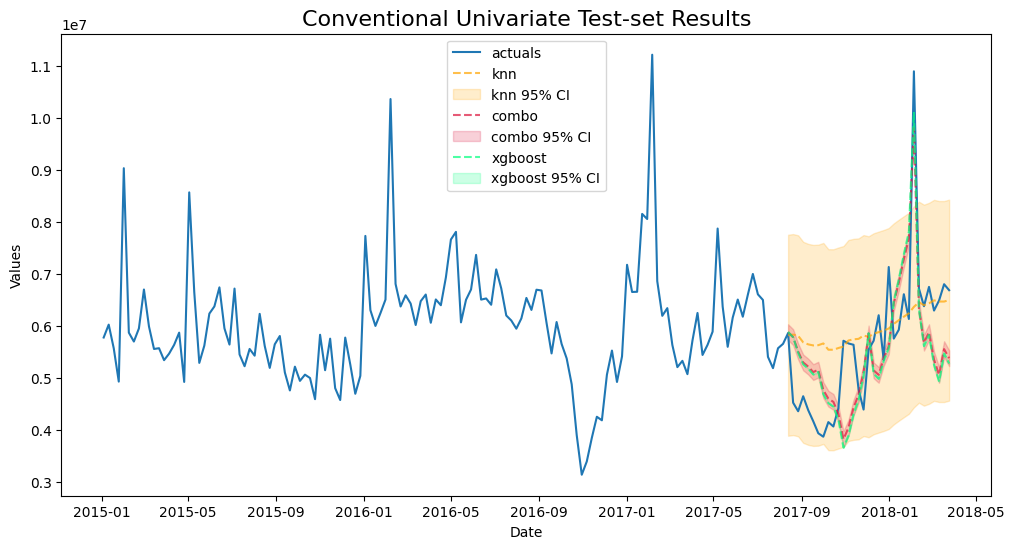

In [211]:
fcon.plot_test_set(ci=True,order_by='LevelTestSetMAPE')
plt.title('Conventional Univariate Test-set Results',size=16)
plt.show()

#### Organic

In [231]:
forg.tune_test_forecast(models,feature_importance=True)
forg.set_estimator('combo')
forg.manual_forecast(how='weighted')

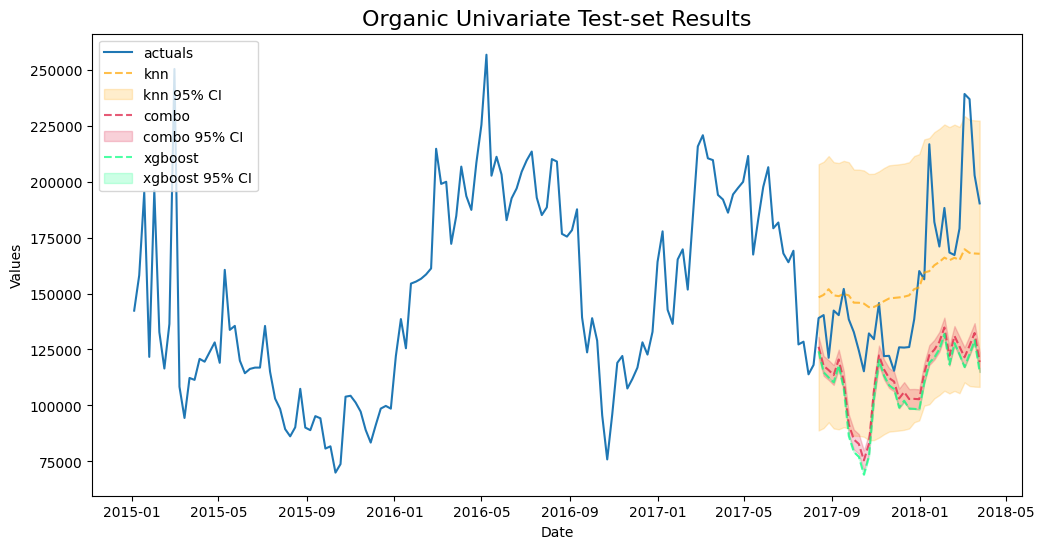

In [232]:
forg.plot_test_set(ci=True,order_by='LevelTestSetMAPE')
plt.title('Organic Univariate Test-set Results',size=16)
plt.show()

### Feature Importance
By default, scalecast uses permutation feature importance from ELI5. After calling a model, the model object from sklearn is available using `f.regr` and that object can be used to export other types of feature importances.

#### Conventional
- Best model: xgboost

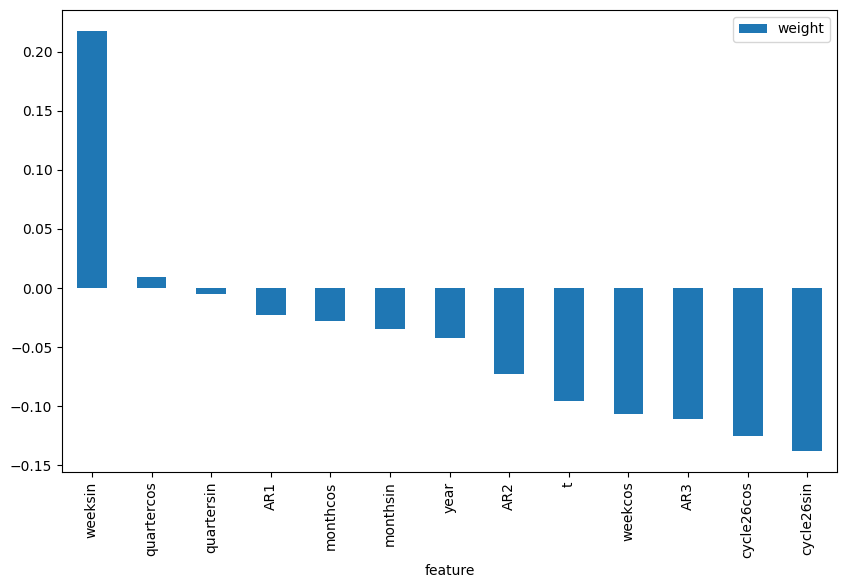

In [233]:
fcon.export_feature_importance('xgboost').plot.bar(y='weight')
plt.show()

#### Organic
- Best model: rf

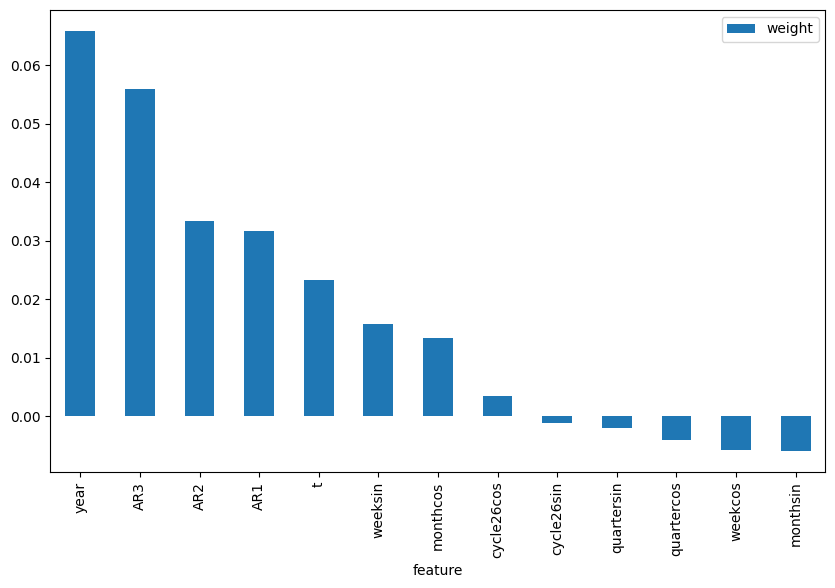

In [234]:
forg.export_feature_importance('knn').plot.bar(y='weight')
plt.show()

### Model Summaries

In [235]:
pd.set_option('display.float_format',  '{:.4f}'.format)
ms = export_model_summaries({'Conventional':fcon,'Organic':forg},determine_best_by='LevelTestSetMAPE')
ms[
    [
        'ModelNickname',
        'Series',
        'Integration',
        'LevelTestSetMAPE',
        'LevelTestSetR2',
        'InSampleMAPE',
        'InSampleR2',
        'best_model'
    ]
]

,ModelNickname,Series,Integration,LevelTestSetMAPE,LevelTestSetR2,InSampleMAPE,InSampleR2,best_model
0,knn,Conventional,0,0.1542,0.2332,0.1145,0.3112,True
1,combo,Conventional,0,0.1589,0.4549,0.0095,0.9952,False
2,xgboost,Conventional,0,0.1629,0.4123,0.0000,1.0000,False
3,knn,Organic,0,0.1279,0.3827,0.1736,0.5179,True
4,combo,Organic,0,0.2522,-1.2020,0.0145,0.9966,False
5,xgboost,Organic,0,0.2781,-1.5108,0.0001,1.0000,False


Because running so many models can cause overfitting on the test set, we can check the average test error between all models to get another metric of how effective our modeling process is.

In [236]:
print('-'*100)
for series in ms['Series'].unique():
    print('univariate average test MAPE for {}: {:.4f}'.format(series,ms.loc[ms['Series'] == series,'LevelTestSetMAPE'].mean()))
    print('univariate average test R2 for {}: {:.2f}'.format(series,ms.loc[ms['Series'] == series,'LevelTestSetR2'].mean()))
    print('-'*100)

----------------------------------------------------------------------------------------------------
univariate average test MAPE for Conventional: 0.1586
univariate average test R2 for Conventional: 0.37
----------------------------------------------------------------------------------------------------
univariate average test MAPE for Organic: 0.2194
univariate average test R2 for Organic: -0.78
----------------------------------------------------------------------------------------------------


These are interesting error metrics, but a lot of models, including XGBoost and GBT appear to be overfitting. Let's see if we can beat the results with a multivariate approach.

## Scalecast - Multivariate

### Set MV Parameters
- Forecast horizon already set
- Xvars already set
- Test size must be set: 20%
- Validation size must be set: 4 periods

In [237]:
mvf = MVForecaster(fcon,forg,names=['Conventional','Organic']) # init the mvf object
mvf.set_test_length(.2)
mvf.set_validation_length(4)
mvf

MVForecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    N_series=2
    SeriesNames=['Conventional', 'Organic']
    ForecastLength=52
    Xvars=['weeksin', 'weekcos', 'monthsin', 'monthcos', 'quartersin', 'quartercos', 'year', 't', 'cycle26sin', 'cycle26cos']
    TestLength=33
    ValidationLength=4
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=mlr
    OptimizeOn=mean
    GridsFile=MVGrids
)

### View Series Correlation

In [238]:
mvf.corr()

,Conventional,Organic
Conventional,1.0000,0.4802
Organic,0.4802,1.0000


### View Series Correlation with each others' lags

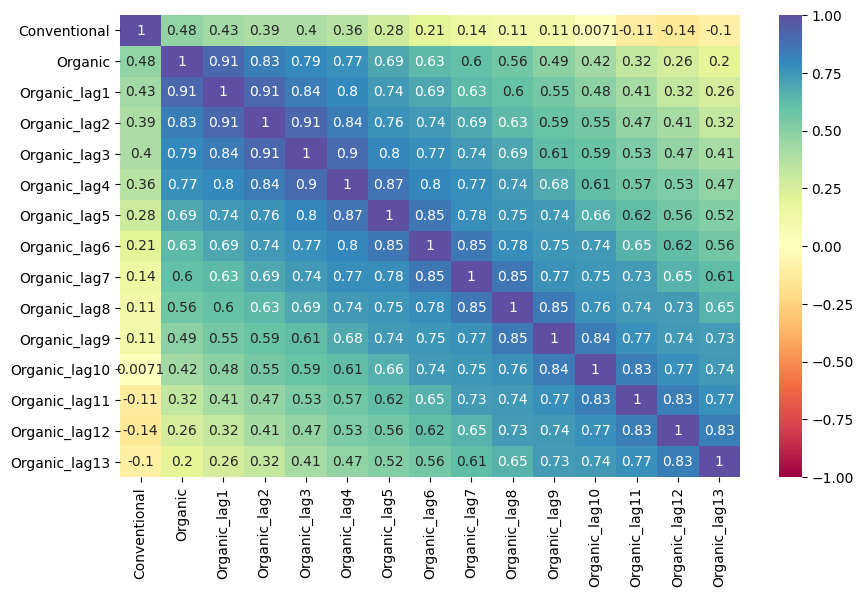

In [239]:
mvf.corr_lags(
    y='Conventional',
    x='Organic',
    lags=13,
    disp='heatmap',
    annot=True,
    vmin=-1,
    vmax=1,
    cmap = 'Spectral',
)
plt.show()

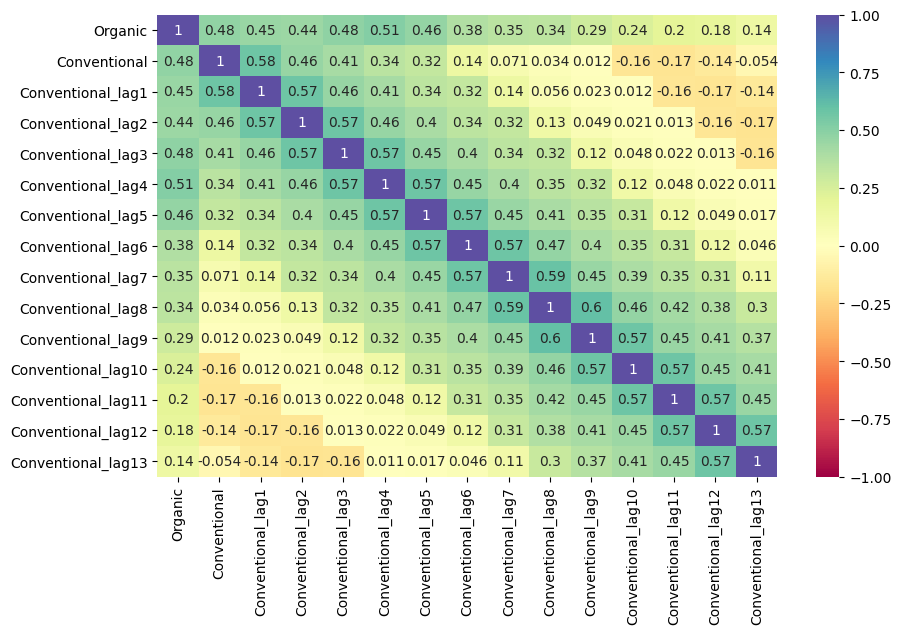

In [240]:
mvf.corr_lags(
    y='Organic',
    x='Conventional',
    lags=13,
    disp='heatmap',
    annot=True,
    vmin=-1,
    vmax=1,
    cmap = 'Spectral',
)
plt.show()

### Set Optimize On
- If predicting one series is more important than predicting the other, you can use this code to let the code know to favor one over the other
- By default, it uses the mean error metrics between all series

In [241]:
# how to optimize on one series
mvf.set_optimize_on('Organic')
# how to optimize using a weighted avarage
mvf.add_optimizer_func(lambda x: x[0]*.25 + x[1]*.75,'weighted')
mvf.set_optimize_on('weighted')
# how to optimize on the average of both/all series (default)
mvf.set_optimize_on('mean')

### Tune and Test with Selected Models

In [242]:
print(models)
mvf.tune_test_forecast(models)
mvf.set_best_model(determine_best_by='LevelTestSetMAPE')

('knn', 'xgboost')


In [ ]:
# not plotting both series at the same time because they have significantly different scales
mvf.plot_test_set(series='Conventional',put_best_on_top=True,ci=True)
plt.title('Conventional Multivariate Test-set Results',size=16)
plt.show()

In [ ]:
mvf.plot_test_set(series='Organic',put_best_on_top=True,ci=True)
plt.title('Organic Multivariate Test-set Results',size=16)
plt.show()

### Export Model Summaries

In [ ]:
pd.options.display.max_colwidth = 100
results = mvf.export('model_summaries')
results[
    [
        'ModelNickname',
        'Series',
        'HyperParams',
        'LevelTestSetMAPE',
        'LevelTestSetR2',
        'InSampleMAPE',
        'InSampleR2',
        'Lags'
    ]
]

### Import a Foreign Sklearn Estimator for Ensemble Modeling

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
estimators = [
    ('mlr',LinearRegression()),
    # ('elasticnet',ElasticNet(**results.loc[results['ModelNickname'] == 'elasticnet','HyperParams'].values[0])),
    # ('mlp',MLPRegressor(**results.loc[results['ModelNickname'] == 'mlp','HyperParams'].values[0]))
]

final_estimator = KNeighborsRegressor(**results.loc[results['ModelNickname'] == 'knn','HyperParams'].values[0])

In [ ]:
mvf.add_sklearn_estimator(StackingRegressor,'stacking')
mvf.set_estimator('stacking')
mvf.manual_forecast(estimators=estimators,final_estimator=final_estimator,lags=13)

In [ ]:
mvf.plot_test_set(series='Conventional',put_best_on_top=True,ci=True)
plt.title('Conventional Multivariate Test-set Results - Added Stacking',size=16)
plt.show()

In [ ]:
mvf.plot_test_set(series='Organic',put_best_on_top=True,ci=True)
plt.title('Organic Multivariate Test-set Results - Added Stacking',size=16)
plt.show()

In [ ]:
mvf.set_best_model(determine_best_by='LevelTestSetMAPE')
results2 = mvf.export('model_summaries')
results2[
    [
        'ModelNickname',
        'Series',
        'LevelTestSetMAPE',
        'LevelTestSetR2',
        'InSampleMAPE',
        'InSampleR2',
        'Lags',
        'best_model'
    ]
]

In [ ]:
print('-'*100)
for series in results2['Series'].unique():
    print('multivariate average test MAPE for {}: {:.4f}'.format(series,results2.loc[results2['Series'] == series,'LevelTestSetMAPE'].mean()))
    print('multivariate average test R2 for {}: {:.2f}'.format(series,results2.loc[results2['Series'] == series,'LevelTestSetR2'].mean()))
    print('-'*100)

### Plot Final Forecasts

In [ ]:
mvf.plot(series='Conventional',models='knn',ci=True)
plt.title('Elasticnet Forecast - Conventional - MAPE 0.1168',size=16)
plt.show()

In [ ]:
mvf.plot(series='Organic',models='knn',ci=True)
plt.title('KNN Forecast - Organic - MAPE 0.0889',size=16)
plt.show()

All-in-all, better results on the test-set were obtained by using the multivariate approach, considering the top-performing models only. Considering the average errors of all models, the univariate may have been the superior approach. The Elasticnet was chosen as the best model for the conventional series, KNN for the organic.